# Building a predictive model - Part I

__`Step 1`__ Import all the needed libraries.

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

############################################ FEATURE SELECTION ############################################
#!pip install scipy
import scipy.stats as stats
from scipy.stats import chi2_contingency # filter method
from sklearn.feature_selection import RFE # wrapper method
from sklearn.linear_model import LogisticRegression #(This is one possible model to apply inside RFE)
from sklearn.linear_model import LassoCV # embedded method
from sklearn.tree import DecisionTreeClassifier # embedded method

import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="1st-bullet">

# 1. Import data (Data Integration)

</a>

__`Step 2`__ Import the train dataset and define the index as the `EmployeeNumber`.

In [2]:
df = pd.read_csv('HR_DS.csv')
df.set_index('EmployeeNumber', inplace=True)
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,3,...,4,80,1,10,3,3,10,7,1,7
4,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
5,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,4,...,3,80,0,8,3,3,8,7,3,0
7,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,3,...,3,80,1,17,3,3,5,2,0,3
2062,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,4,...,1,80,1,9,5,3,7,7,1,7
2064,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2,...,2,80,1,6,0,3,6,2,0,3


In [3]:
from sklearn.model_selection import StratifiedKFold

In [4]:
skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)

In [5]:
X = df.drop('Attrition', axis = 1)
y = df['Attrition'].copy()

In [6]:
def apply_chisquare(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [7]:
def select_best_cat_features(X,y):
    count = 1
    
    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        
        #################################### SELECT FEATURES WITH CHI-SQUARE #######################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using chi-square
        X_train_cat = X_train[['BusinessTravel','Department','EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']].copy()
        for var in X_train_cat:
            apply_chisquare(X_train_cat[var],y_train, var)
            
        count+=1

In [8]:
select_best_cat_features(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
BusinessTravel is IMPORTANT for Prediction
Department is IMPORTANT for Prediction
EducationField is IMPORTANT for Prediction
Gender is NOT an important predictor. (Discard Gender from model)
JobRole is IMPORTANT for Prediction
MaritalStatus is IMPORTANT for Prediction
Over18 is NOT an important predictor. (Discard Over18 from model)
OverTime is IMPORTANT for Prediction
_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________
BusinessTravel is IMPORTANT for Prediction
Department is IMPORTANT for P

#### What can we conclude?

| Predictor | Chi-Square | What to do? (One possible way to "solve")|
| --- | --- | --- |
| BusinessTravel | 5 YES | Keep |
| Department | 5 YES | Keep |
| OverTime | 5 YES | Keep |
| Department | 5 YES | Keep |
| Department | 5 YES | Keep |
| EducationField | 4 YES & 1 NO |Remove|
| Gender | 5 NO |Remove|
| Over18 | 5 NO |Remove|

In [9]:
def apply_variance(X_train):
    X_train_numeric = X_train.select_dtypes(include=['number'])
    print(X_train_numeric.var())

In [10]:
def select_features_variance(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using variance
        apply_variance(X_train)
            
        count+=1

In [11]:
select_features_variance(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Age                         8.542577e+01
DailyRate                   1.630649e+05
DistanceFromHome            6.529640e+01
Education                   1.050976e+00
EmployeeCount               0.000000e+00
EnvironmentSatisfaction     1.219349e+00
HourlyRate                  4.076624e+02
JobInvolvement              5.056680e-01
JobLevel                    1.268768e+00
JobSatisfaction             1.201251e+00
MonthlyIncome               2.303965e+07
MonthlyRate                 5.080834e+07
NumCompaniesWorked          6.148617e+00
PercentSalaryHike           1.323087e+01
PerformanceRating           1.243704e-01
RelationshipSatisfaction    1.149805e+00
StandardHours               0.000000e+00
StockOptionLevel         

#### What can we conclude?

- `EmployeeCount` and `StandardHours` are constant features. We should remove those.

In [12]:
X = X.drop(['EmployeeCount', 'StandardHours'], axis = 1)

In [44]:
def cor_heatmap(cor):
    plt.figure(figsize=(10,6))
    sns.heatmap(data = cor, annot = True, fmt=".1f", cmap = plt.cm.Reds, annot_kws={"size": 8})
    plt.show()

In [45]:
def apply_correlation(X_train):
    correlation_data = X_train.select_dtypes(include=['number'])
    matrix = correlation_data.corr(method = 'spearman')
    cor_heatmap(matrix)

In [46]:
def redundant_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # check which features to use using spearman correlation
        apply_correlation(X_train)
        
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


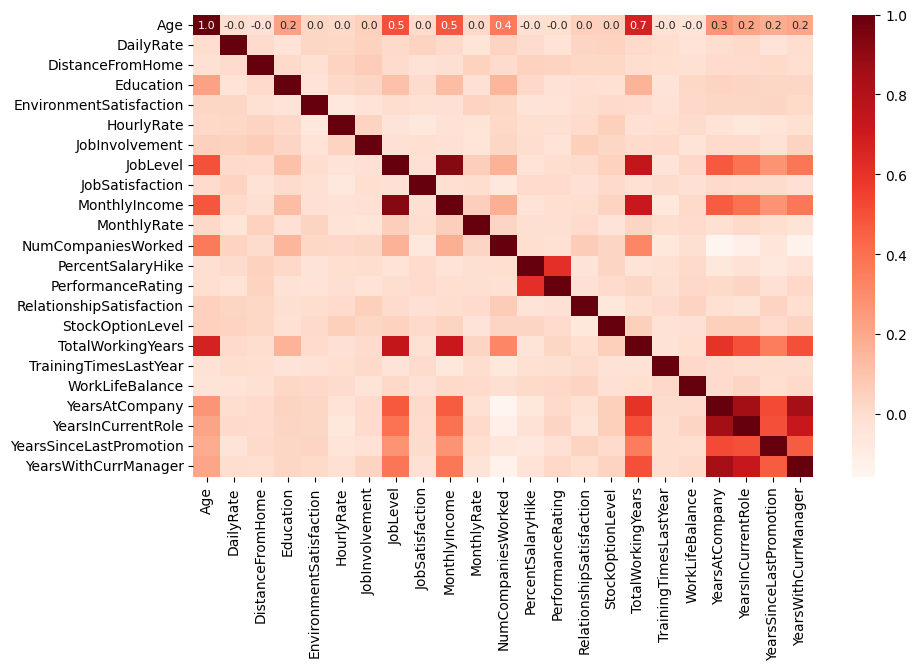

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


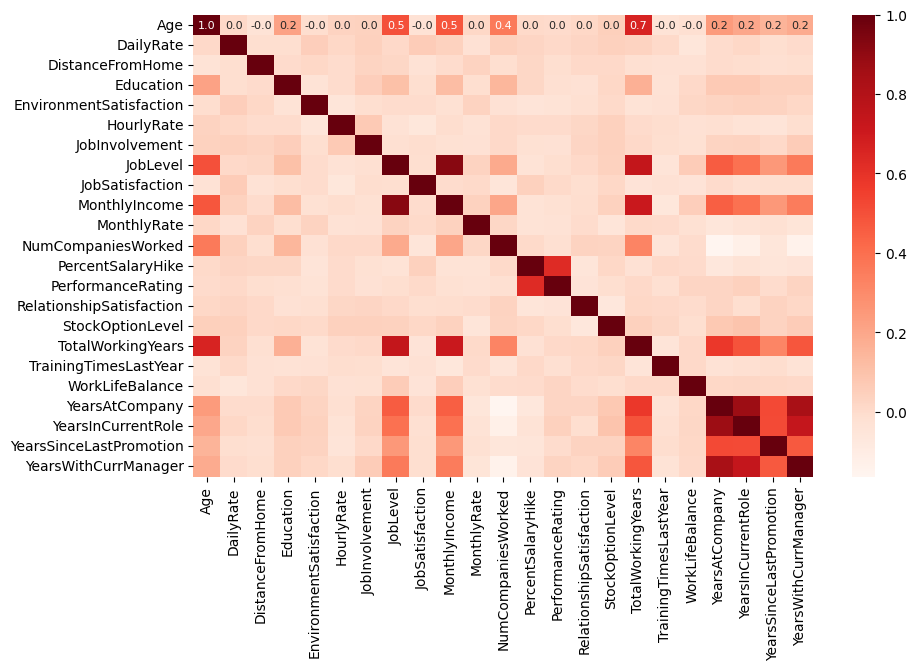

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


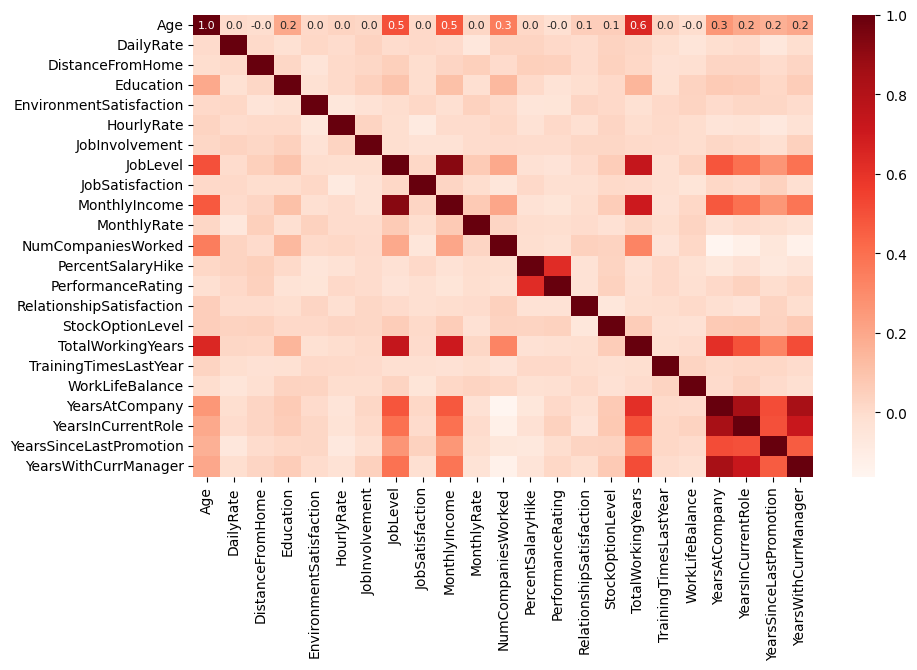

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


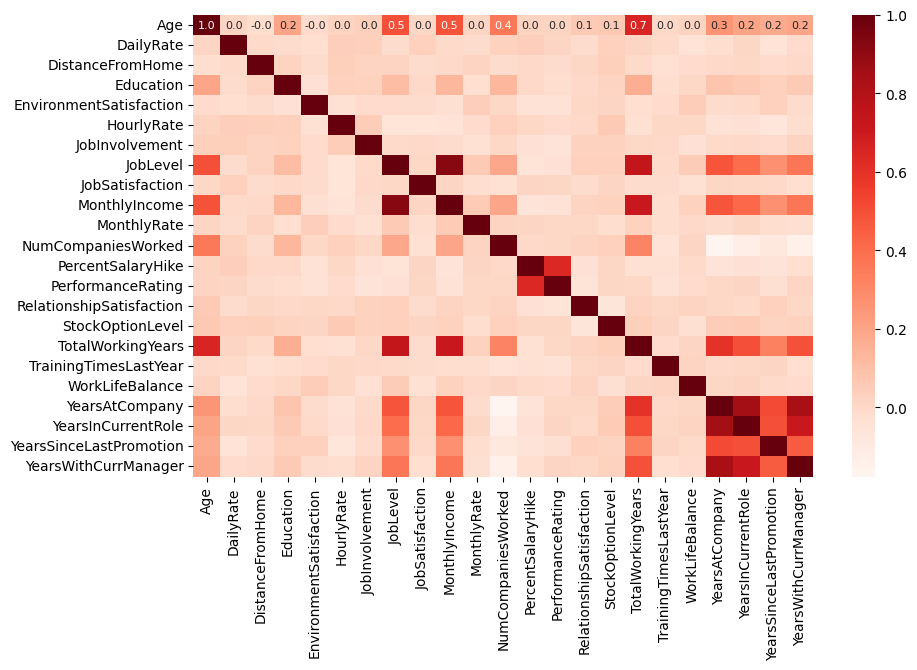

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


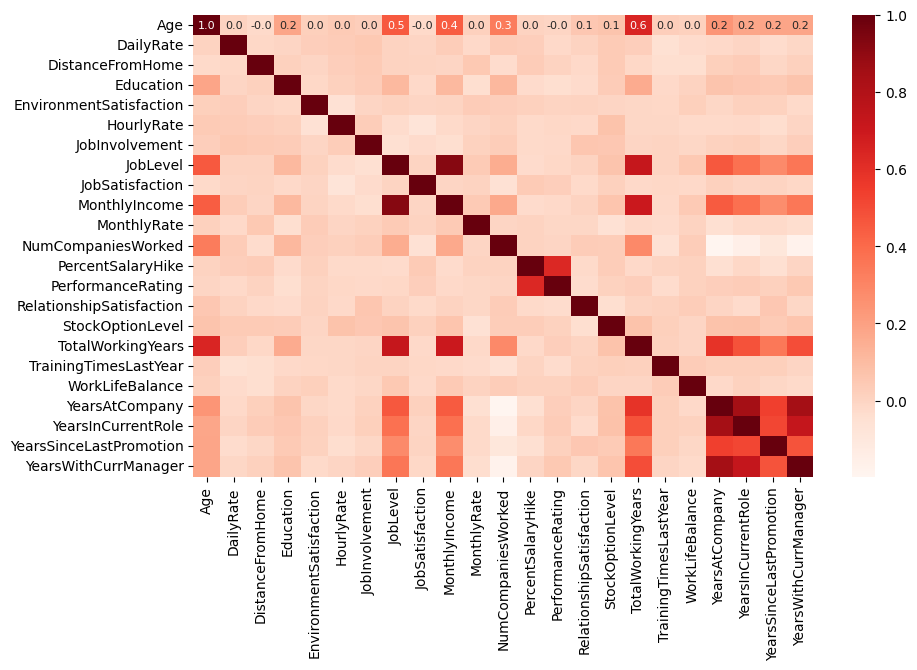

In [47]:
redundant_features(X, y)

In [33]:
num = df[['Age','DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']]

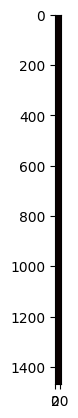

In [34]:
plt.imshow(num, cmap='hot', interpolation='nearest')
plt.show()